# Imports

In [10]:
import torch
from torch import nn
from torchtext.legacy.datasets import TranslationDataset
from torchtext.legacy.data import Field
from torchtext.legacy.data import Iterator
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.model import TransformerModel
from src.helper import save_state, load_state
import os

# Training Class

In [51]:
class Trainer():
    def __init__(self, data_constants : dict, parameters : dict):
        """
        This function creates the dataset, the iterator, the model, and the optimizer
        
        :param data_constants: A dictionary containing the following keys:
        :type data_constants: dict
        :param parameters: 
        :type parameters: dict
        """
        self.device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")
        _source_field, _target_field = self._create_fields(batch_first = True)
        train_dataset, valid_dataset, self.train_iterator, self.valid_iterator = self._create_dataset(data_constants, _source_field, _target_field)
        _source_field.build_vocab(train_dataset)
        _target_field.build_vocab(train_dataset)
        self.source_field = _source_field
        self.target_field = _target_field
        self.train_iterator.create_batches
        self.valid_iterator.create_batches
        self._validation_accuracy = []
        self._training_accuracy = []
        self._train_loss = []
        self._validation_loss = []
        self._total_count = []
        self.dataset_name = data_constants['folder'].rsplit('/', 1)[-1]
        self.model = TransformerModel(**parameters, src_tokens = len(self.source_field.vocab), tgt_tokens = len(self.target_field.vocab), device = self.device, target_field = self.target_field).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
    
    def greedy_search(self,model,bs,src,seq_length=None):
        """
        This function takes the source sentence, encodes it, and then decodes it one word at a time, using the
        previous word as the input to the decoder
        
        :param model: the model to be used for inference
        :param bs: batch size
        :param src: The source sentence
        :param seq_length: The length of the sequence to be generated. If None, the sequence will be
        generated until the model predicts the end of sentence token
        :return: The logits and the argmax of the logits
        """
        model.eval()
        trg = torch.tensor([self.target_field.vocab.stoi[self.target_field.init_token]]*bs).long().to(self.device)
        trg = trg.view(bs,-1)
        src_key_padding_mask,memory_key_padding_mask,_,src_pos_encoder= model.generate_masks_and_encoding(src,src_embedding=True)
        memory_tensor = model.transformer.encoder(src_pos_encoder, src_key_padding_mask = src_key_padding_mask).to(self.device)
        count = 1
        while True:
            tgt_key_padding_mask,tgt_mask,tgt_pos_encoder=model.generate_masks_and_encoding(trg,src_embedding=False)
            prediction = model.transformer.decoder(tgt_pos_encoder,memory_tensor, tgt_key_padding_mask = tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask = tgt_mask)
            logits = model.fc(prediction.transpose(1,0))
            ix = torch.argmax(logits,dim=2)[:,-1]
            trg = torch.cat([trg,ix.view(bs, -1)],dim=1)
            if seq_length == None and (ix == self.target_field.vocab.stoi[self.target_field.eos_token]).all():
                break
            elif seq_length != None and count >= seq_length:
                break
            count+=1
        return logits, torch.argmax(logits,dim=2)

    def train_model(self, total_batches_processed, num_epochs : int = 20, hyperparameter_tuning = False):
        """
        The function takes in the number of batches processed, the number of epochs to train for, and a
        boolean value to indicate whether or not hyperparameter tuning is being performed. It then
        trains the model for the specified number of epochs, and saves the model, optimizer, and
        training statistics every 500 batches.
        
        :param total_batches_processed: This is the number of batches that have been processed so far.
        This is used to keep track of the number of batches processed
        :param num_epochs: Number of epochs to train the model for, defaults to 20
        :type num_epochs: int (optional)
        :param hyperparameter_tuning: If you want to tune the hyperparameters, set this to True,
        defaults to False (optional)
        """
        loss_fn = nn.CrossEntropyLoss(ignore_index=self.source_field.vocab.stoi[self.source_field.pad_token])
        cost = []
        train_accuracy=0
        total_train = 0
        valid_accuracy = 0
        correct_train = 0
        for epoch in range(1,num_epochs+1):
            if hyperparameter_tuning == True and valid_accuracy == 100.0: break
            print()
            print("__________________________________________________________________________________________________________________________________________")
            print(f'Epoch Number: {epoch}')
            print("__________________________________________________________________________________________________________________________________________")
            print()
            num_batch_processed = 0
            for batch in self.train_iterator:
                self.model.train()
                src = batch.src.to(self.device)
                trg = batch.trg.to(self.device)
                trg_labels = trg[:,1:]
                prediction = self.model(src,trg[:,:-1])
                loss = loss_fn(prediction.permute(0,2,1), trg_labels)
                cost.append(loss.item())
                loss.backward()
                num_batch_processed += 1
                total_batches_processed += 1
                pred_max = torch.argmax(prediction, dim=2)        
                total_train += trg_labels.size(0)
                correct_train += torch.sum(((pred_max == trg_labels) | (trg_labels == self.source_field.vocab.stoi[self.source_field.pad_token])).all(1))
                if num_batch_processed%5==0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.1)
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                if total_batches_processed%500==0:
                    train_accuracy = 100* (correct_train/total_train)
                    self._training_accuracy.append(train_accuracy.cpu())
                    total_train = 0
                    correct_train = 0
                    with torch.no_grad():
                        self.model.eval()
                        valid_cost = []
                        correct = 0
                        total = 0
                        for batch in self.valid_iterator:
                          src = batch.src.to(self.device)
                          trg = batch.trg.to(self.device)
                          valid_labels = trg[:,1:]
                          prediction, _= self.greedy_search(self.model, src.size(0),src, valid_labels.size(1))
                          loss = loss_fn(prediction.permute(0,2,1),valid_labels)
                          valid_cost.append(loss.item())
                          total += valid_labels.size(0)
                          pred_max = torch.argmax(prediction, dim=2)
                          correct += torch.sum(((pred_max == valid_labels) | (valid_labels == self.source_field.vocab.stoi[self.source_field.pad_token])).all(1))
                        valid_accuracy = 100 * (correct / total)
                        self._validation_accuracy.append(valid_accuracy.cpu())
                    print("Steps:", total_batches_processed)
                    sentences = ["What is the tens digit of 93283843?", "What is the units digit of 93215897?", "What is the thousands digit of 58179700?"]
                    sentence_targets = ["4", "7", "9"]
                    # sentences = ["Put 0.4, 5, 30, 50, -2, 16 in descending order.","Sort -25/127, -2/13, 0.2.","Sort 3, -0.2, 927897, 3/7 in ascending order."]
                    # sentence_targets = ["50, 30, 16, 5, 0.4, -2","-25/127, -2/13, 0.2","-0.2, 3/7, 3, 927897"]
                    # sentences = ["Solve -282*d + 929 - 178 = -1223 for d.", "Solve 0 = -i - 91*i - 1598*i - 64220 for i.", "Solve -25*m - 2084 = -2559 for m."]
                    # sentence_targets = ["7", "-38", "19"]
                    for sentence in sentences:
                        src = self.source_field.process([sentence]).to(self.device)
                        _,decoded = self.greedy_search(self.model, 1, src.view(1,-1))
                        pred = [self.target_field.vocab.itos[ind] for ind in decoded[0]]
                        print(f"Example Question: {sentence} | Expected Answer: {sentence_targets[sentences.index(sentence)]} | Generated Answer: {''.join(pred)}")
                    self._train_loss.append(np.mean(cost))
                    self._validation_loss.append(np.mean(valid_cost))
                    print()
                    print(f'Train Accuracy {train_accuracy}%')
                    print(f'Valid Accuracy {valid_accuracy} %')
                    print(f'Train Loss: {np.mean(cost)}')
                    print("Val Loss:",np.mean(valid_cost))
                    print("__________________________________________________________________________________________________________________________________________")
                    print()
                    cost = []
                    self._total_count.append(total_batches_processed)
                    if not os.path.exists('Results'): os.mkdir('Results')
                    save_state(os.path.join("Results",f"model_{self.dataset_name}.pt"),self.model, self.optimizer, total_batches_processed, self._total_count, self._validation_accuracy, self._training_accuracy, self._train_loss, self._validation_loss)
                    if hyperparameter_tuning == True and valid_accuracy == 100.0:
                        print("Final Accuracy for Validation:", valid_accuracy)
                    break
    def _create_fields(self, batch_first : bool = True):
        """
        The function takes in a boolean value and returns two fields, one for the source and one for
        the target
        
        :param batch_first: Whether the first dimension of the data is the batch dimension, defaults to
        True
        :type batch_first: bool (optional)
        :return: A tuple of two fields, one for the source and one for the target.
        """
        _source_field = Field(tokenize = lambda x: list(x),
                            init_token = '<sos>',
                            eos_token = '<eos>',
                            pad_token = '<pad>',
                            batch_first = batch_first)
        _target_field = Field(tokenize = lambda x: list(x),
                            init_token = '<sos>',
                            eos_token = '<eos>',
                            pad_token = '<pad>',
                            batch_first = batch_first)
        return _source_field, _target_field

    def _create_dataset(self, data_constants : dict, source_field, target_field):
        """
        This function creates a train and validation dataset from the data in the folder specified in
        the data_constants dictionary
        
        :param data_constants: a dictionary containing the following keys:
        :type data_constants: dict
        :param source_field: The field that will be used for the source sentence
        :param target_field: The field that will be used for the target language
        """
        _train_dataset, _valid_dataset, _ = TranslationDataset.splits(
            path = data_constants['folder'],
            root = data_constants['folder'],
            exts = (data_constants['inputs_ending'], data_constants['targets_ending']),
            fields = (source_field, target_field),
            train = data_constants['train_name'],
            validation = data_constants['valid_name'],
            test = data_constants['valid_name']
        )
        _train_iterator = Iterator(dataset=_train_dataset, batch_size = data_constants['train_batch_size'], train=True, repeat=False, shuffle=True, device=self.device) 
        _valid_iterator = Iterator(dataset=_valid_dataset, batch_size = data_constants['valid_batch_size'], train=False, repeat=False, shuffle=True, device=self.device) 
        return _train_dataset, _valid_dataset, _train_iterator, _valid_iterator

# Hyperparameters and Constants

In [ ]:
TRAIN_BS = 128
VALID_BS = 64
DATASET_NAME = 'numbers__place_value'
DATA_FOLDER = os.path.join("data",DATASET_NAME)
TRAIN_FILE_NAME = "train"
VALID_FILE_NAME = "interpolate"
INPUTS_FILE_ENDING = ".x"
TARGETS_FILE_ENDING = ".y"

DIM_MODEL = 256
DIM_FEEDFORWARD = 1024
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 2
NUM_HEADS = 8

data_constants = {
    'folder' : DATA_FOLDER,
    'train_name' : TRAIN_FILE_NAME,
    'valid_name' : VALID_FILE_NAME,
    'inputs_ending' : INPUTS_FILE_ENDING,
    'targets_ending' : TARGETS_FILE_ENDING,
    'train_batch_size' : TRAIN_BS,
    'valid_batch_size' : VALID_BS
    }
parameters = {
    'd_model' : DIM_MODEL,
    'nhead' : NUM_HEADS,
    'dim_feedforward' : DIM_FEEDFORWARD,
    'num_encoder_layers' : NUM_ENCODER_LAYERS,
    'num_decoder_layers' : NUM_DECODER_LAYERS
}
total_batches = 0

# Training and visualisation

In [52]:
trainer = Trainer(data_constants=data_constants, parameters=parameters)
trainer.train_model(total_batches_processed=total_batches, num_epochs=100, hyperparameter_tuning=True)


__________________________________________________________________________________________________________________________________________
Epoch Number: 1
__________________________________________________________________________________________________________________________________________

Steps: 500
Example Question: What is the tens digit of 93283843? | Expected Answer: 4 | Generated Answer: 3<eos>
Example Question: What is the units digit of 93215897? | Expected Answer: 7 | Generated Answer: 9<eos>
Example Question: What is the thousands digit of 58179700? | Expected Answer: 9 | Generated Answer: 7<eos>

Train Accuracy 28.27187728881836%
Valid Accuracy 35.119998931884766 %
Train Loss: 0.9777513715028763
Val Loss: 0.7867772985415854
__________________________________________________________________________________________________________________________________________


_____________________________________________________________________________________________________________

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
[tensor(35.1200), tensor(34.1200), tensor(37.9600), tensor(50.5000), tensor(71.0700), tensor(76.2700), tensor(91.5700), tensor(97.4500), tensor(100.)]


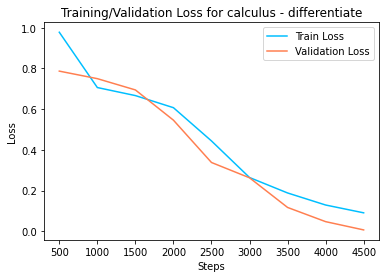

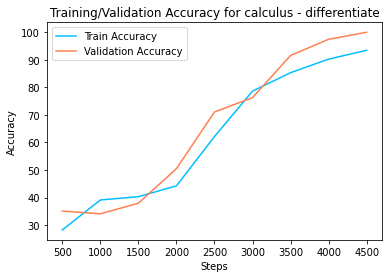

In [53]:
trainer = Trainer(data_constants=data_constants, parameters=parameters)
model_folder = os.path.join("Results", f'model_{DATASET_NAME}.pt')
model, optimizer, total_batches, total_count, validation_accuracy, training_accuracy, train_loss, validation_loss = load_state(model_folder,trainer.model,trainer.optimizer, total_batches,trainer._total_count,
                                                                                                                               trainer._validation_accuracy,trainer._training_accuracy,trainer._train_loss,trainer._validation_loss)
print(optimizer)
state = torch.load(model_folder)
print(state["validation_acc"])
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
ax1.plot(total_count,train_loss, 'deepskyblue')
ax1.plot(total_count,validation_loss, 'coral')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.legend(["Train Loss", "Validation Loss"])
ax1.title.set_text(f"Training/Validation Loss for numbers - place value")
ax2.plot(total_count,training_accuracy,'deepskyblue')
ax2.plot(total_count,validation_accuracy,'coral')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Accuracy')
ax2.legend(["Train Accuracy", "Validation Accuracy"])
ax2.title.set_text("Training/Validation Accuracy for numbers - place value")
plt.show()
